# **IMPORT STATEMENTS**

In [145]:
#IMPORT STATEMENTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **LOAD THE DATASET**

In [146]:
df=pd.read_csv("/kaggle/input/ibm-transactions-for-anti-money-laundering-aml/HI-Small_Trans.csv")

In [147]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5078345 entries, 0 to 5078344
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Timestamp           object 
 1   From Bank           int64  
 2   Account             object 
 3   To Bank             int64  
 4   Account.1           object 
 5   Amount Received     float64
 6   Receiving Currency  object 
 7   Amount Paid         float64
 8   Payment Currency    object 
 9   Payment Format      object 
 10  Is Laundering       int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 426.2+ MB


# **DROP THE DUPLICATES**

In [149]:
df.drop_duplicates(inplace=True)

In [150]:
df.shape

(5078336, 11)

# **Data Distribution**

In [151]:
df["Is Laundering"].value_counts()

Is Laundering
0    5073159
1       5177
Name: count, dtype: int64

In [152]:
df["Is Laundering"].value_counts(normalize=True)*100

Is Laundering
0    99.898057
1     0.101943
Name: proportion, dtype: float64

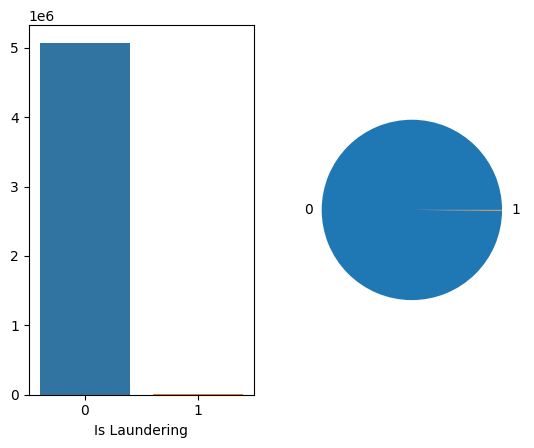

In [153]:
target_count=df["Is Laundering"].value_counts()
plt.subplot(1,2,1)
sns.barplot(x=target_count.index,y=target_count.values)
plt.subplot(1,2,2)
plt.pie(target_count.values,labels=target_count.index);

# **Deal  with TimeStamps**

In [154]:
# Convert the "Timestamp" column to datetime format
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Extract Date, Day, and Time from the Timestamp
df["Date"] = df["Timestamp"].dt.date
df["Day"] = df["Timestamp"].dt.day_name()
df["Time"] = df["Timestamp"].dt.time                                              

df.drop(columns=["Timestamp"], inplace=True)

In [155]:
df.head(2)

,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Date,Day,Time
0,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0,2022-09-01,Thursday,00:20:00
1,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0,2022-09-01,Thursday,00:20:00


# **Define the X and Y**

In [156]:
X = df.drop(['Is Laundering'],axis = 1)
y = df['Is Laundering']

# **Under Sampling for dealing with Imbalanced Dataset**

In [157]:
# Define the undersampler
from imblearn.under_sampling import RandomUnderSampler
undersampler = RandomUnderSampler()

In [158]:
X,y=undersampler.fit_resample(X,y)

# **SPLITTING**

In [159]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

# **ONE HOT ENCODING with PIPELINE**

In [160]:
categorical = ['From Bank','Account','To Bank','Receiving Currency','Payment Currency','Payment Format','Day']

In [161]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
ohe = Pipeline([('Encoder',OneHotEncoder(drop = 'first',handle_unknown='ignore'))])

In [162]:
from sklearn.compose import ColumnTransformer
transformer = ColumnTransformer([('One Hot Encoding',ohe,categorical)])

In [163]:
from xgboost import XGBClassifier
# Define the full pipeline without the undersampler
model = Pipeline([
    ('Transformer', transformer),           # Preprocess the data
    ('Estimator', XGBClassifier())          # Train the model with XGBoost
])

# **Fitting the model**

In [164]:
model.fit(X_train,y_train)

Pipeline(steps=[('Transformer',
                 ColumnTransformer(transformers=[('One Hot Encoding',
                                                  Pipeline(steps=[('Encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['From Bank', 'Account',
                                                   'To Bank',
                                                   'Receiving Currency',
                                                   'Payment Currency',
                                                   'Payment Format',
                                                   'Day'])])),
                ('Estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=No...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

# **PREDICTION**

In [165]:
#Predictions
y_pred = model.predict(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# **EVALUATION**

Text(0.5, 23.52222222222222, 'Predicted Values')

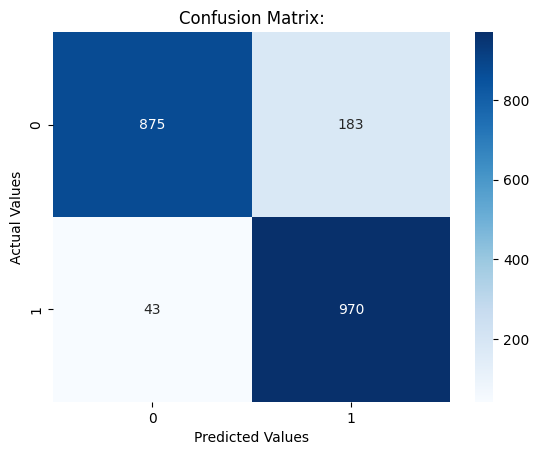

In [166]:
from sklearn.metrics import confusion_matrix
plt.title("Confusion Matrix:")
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")

In [167]:
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1058
           1       0.84      0.96      0.90      1013

    accuracy                           0.89      2071
   macro avg       0.90      0.89      0.89      2071
weighted avg       0.90      0.89      0.89      2071



In [168]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
print("Accuracy Score:", accuracy_score(y_test, y_pred)*100)
print("Precision Score:",precision_score(y_test, y_pred)*100)
print("Recall Score:",recall_score(y_test, y_pred)*100)
print("F1 Score:", f1_score(y_test, y_pred)*100)

Accuracy Score: 89.08739739256399
Precision Score: 84.12836079791848
Recall Score: 95.75518262586377
F1 Score: 89.56602031394276
